<a href="https://colab.research.google.com/github/JeremyKrick/ComposerNet/blob/main/AAI_590_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/rules

# Libraries and Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import dask.dataframe as dd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [ ]:
#@title Kaggle Json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jenniferkblack","key":"741f96f6b3af092ec0f806e689a2e3fd"}'}

In [ ]:
#@title Install Kaggle

! pip install kaggle

In [ ]:
#@title Configure Kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#@title Download Data - H&M

!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

100% 28.7G/28.7G [21:57<00:00, 23.6MB/s]
100% 28.7G/28.7G [21:57<00:00, 23.4MB/s]


In [ ]:
#@title Unzip files

! unzip -n /content/h-and-m-personalized-fashion-recommendations.zip -d /content/drive/MyDrive/h-and-m-personalized-fashion-recommendations


Archive:  /content/h-and-m-personalized-fashion-recommendations.zip


In [ ]:
#@title Download Data - Clothing Reviews

!kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews

 72% 2.00M/2.79M [00:00<00:00, 2.54MB/s]
100% 2.79M/2.79M [00:01<00:00, 2.89MB/s]


In [ ]:
#@title Unzip files

! unzip -n /content/womens-ecommerce-clothing-reviews.zip -d /content/drive/MyDrive/womens-ecommerce-clothing-reviews

Archive:  /content/womens-ecommerce-clothing-reviews.zip


# Data Setup

In [ ]:
file_path = '/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/transactions_train.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [ ]:
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [ ]:
len(df)

31788324

In [ ]:
df.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [ ]:
# Convert the 't_dat' column to datetime format
df['t_dat'] = pd.to_datetime(df['t_dat'])
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [ ]:
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                   int64
price                      float64
sales_channel_id             int64
dtype: object

In [ ]:
# Replace the file path with your actual file path
file_path = '/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/articles.csv'

# Read the CSV file into a DataFrame
df_article_info = pd.read_csv(file_path)

In [ ]:
df_article_info.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

# Feature Store

In [ ]:
# Assuming 'df' and 'df_article_info' are Dask DataFrames
ddf = dd.merge(df, df_article_info, on='article_id', how='inner')

# If 'df' and 'df_article_info' are pandas DataFrames, you can convert them to Dask DataFrames:
ddf = dd.from_pandas(df, npartitions=10)  # You can adjust the number of partitions

# Perform the merge operation
merged_ddf = dd.merge(ddf, df_article_info, on='article_id', how='inner')

# Compute the result into a Pandas DataFrame
merged_df = merged_ddf.compute()

In [ ]:
merged_df.dtypes

t_dat                           datetime64[ns]
customer_id                             object
article_id                               int64
price                                  float64
sales_channel_id                         int64
product_code                             int64
prod_name                               object
product_type_no                          int64
product_type_name                       object
product_group_name                      object
graphical_appearance_no                  int64
graphical_appearance_name               object
colour_group_code                        int64
colour_group_name                       object
perceived_colour_value_id                int64
perceived_colour_value_name             object
perceived_colour_master_id               int64
perceived_colour_master_name            object
department_no                            int64
department_name                         object
index_code                              object
index_name   

In [ ]:
# Feature 1: Mean price per product category
mean_price_per_category = merged_df.groupby('product_group_name')['price'].mean()

# Feature 2: Total sales per department
total_sales_per_department = merged_df.groupby('department_name')['sales_channel_id'].sum()

# Feature 3: Maximum price per product type
max_price_per_type = merged_df.groupby('product_type_name')['price'].max()

# Store features in a dictionary
features = {
    'mean_price_per_category': mean_price_per_category,
    'total_sales_per_department': total_sales_per_department,
    'max_price_per_type': max_price_per_type
}

# Save features to a Feather file
for feature_name, feature_data in features.items():
    feature_data.reset_index().to_feather(f'{feature_name}.feather')

In [ ]:
loaded_mean_price_per_category = pd.read_feather('mean_price_per_category.feather')
print(loaded_mean_price_per_category)

       product_group_name     price
0             Accessories  0.015563
1                    Bags  0.033349
2                Cosmetic  0.005848
3                     Fun  0.008885
4               Furniture  0.009591
5       Garment Full body  0.036166
6      Garment Lower body  0.032894
7      Garment Upper body  0.027005
8   Garment and Shoe care  0.017484
9        Interior textile  0.016449
10                  Items  0.011337
11              Nightwear  0.025426
12                  Shoes  0.038749
13         Socks & Tights  0.011391
14             Stationery  0.003205
15               Swimwear  0.022343
16              Underwear  0.021200
17    Underwear/nightwear  0.027850
18                Unknown  0.026780


# EDA

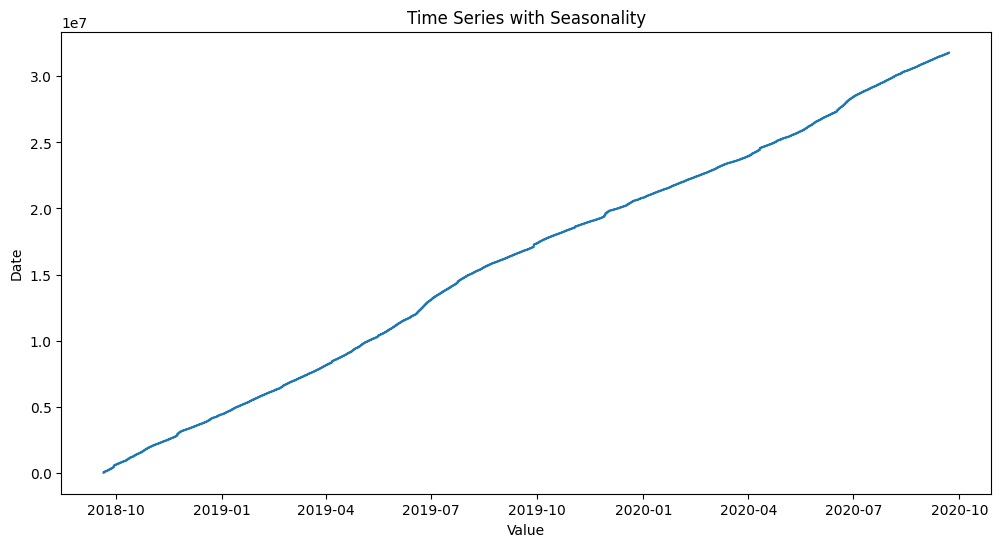

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['t_dat'],df.index)
plt.title('Time Series')
plt.ylabel('Date')
plt.xlabel('Value')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='t_dat', y='value', hue='product_category', data=grouped_df)
plt.title('Time Series Data by Product Category')
plt.xlabel('Date')
plt.ylabel('Aggregated Value')
plt.show()

In [ ]:
merged_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
2,2018-09-20,4ef5967ff17bf474bffebe5b16bd54878e1d4105f7b4ed...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
3,2018-09-20,6b7b10d2d47516c82a6f97332478dab748070f09693f09...,663713001,0.050831,1,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
4,2018-09-20,8ac137752bbe914aa4ae6ad007a9a0c5b67a1ab2b2d474...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."


from matplotlib import pyplot as plt
_df_0['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['sales_channel_id'].plot(kind='hist', bins=20, title='sales_channel_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('customer_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='price', y='sales_channel_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['article_id']
  ys = series['price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('article_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('price')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['article_id']
  ys = series['sales_channel_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('article_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('sales_channel_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['article_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'article_id'}, axis=1)
              .sort_values('article_id', ascending=True))
  xs = counted['article_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('article_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['product_code']
  ys = series['price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('product_code', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('product_code')
_ = plt.ylabel('price')

from matplotlib import pyplot as plt
_df_8['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['sales_channel_id'].plot(kind='line', figsize=(8, 4), title='sales_channel_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['customer_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='price', y='customer_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['customer_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='sales_channel_id', y='customer_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
merged_df.dtypes

t_dat                           datetime64[ns]
customer_id                             object
article_id                               int64
price                                  float64
sales_channel_id                         int64
product_code                             int64
prod_name                               object
product_type_no                          int64
product_type_name                       object
product_group_name                      object
graphical_appearance_no                  int64
graphical_appearance_name               object
colour_group_code                        int64
colour_group_name                       object
perceived_colour_value_id                int64
perceived_colour_value_name             object
perceived_colour_master_id               int64
perceived_colour_master_name            object
department_no                            int64
department_name                         object
index_code                              object
index_name   

In [ ]:
print(merged_df.describe())

         article_id         price  sales_channel_id  product_code  \
count  3.178832e+07  3.178832e+07      3.178832e+07  3.178832e+07   
mean   6.962272e+08  2.782927e-02      1.704028e+00  6.962272e+05   
std    1.334480e+08  1.918113e-02      4.564786e-01  1.334480e+05   
min    1.087750e+08  1.694915e-05      1.000000e+00  1.087750e+05   
25%    6.328030e+08  1.581356e-02      1.000000e+00  6.328030e+05   
50%    7.145820e+08  2.540678e-02      2.000000e+00  7.145820e+05   
75%    7.865240e+08  3.388136e-02      2.000000e+00  7.865240e+05   
max    9.562170e+08  5.915254e-01      2.000000e+00  9.562170e+05   

       product_type_no  graphical_appearance_no  colour_group_code  \
count     3.178832e+07             3.178832e+07       3.178832e+07   
mean      2.462434e+02             1.009727e+06       2.631858e+01   
std       6.779323e+01             1.701311e+04       2.620701e+01   
min      -1.000000e+00            -1.000000e+00      -1.000000e+00   
25%       2.530000e+02      

In [ ]:
print(merged_df.isnull().sum())

t_dat                                0
customer_id                          0
article_id                           0
price                                0
sales_channel_id                     0
product_code                         0
prod_name                            0
product_type_no                      0
product_type_name                    0
product_group_name                   0
graphical_appearance_no              0
graphical_appearance_name            0
colour_group_code                    0
colour_group_name                    0
perceived_colour_value_id            0
perceived_colour_value_name          0
perceived_colour_master_id           0
perceived_colour_master_name         0
department_no                        0
department_name                      0
index_code                           0
index_name                           0
index_group_no                       0
index_group_name                     0
section_no                           0
section_name             

In [ ]:
# Assuming 'df_article_info' is your DataFrame
num_garment_groups = df_article_info['garment_group_name'].nunique()

print(f"Number of Garment Groups: {num_garment_groups}")

Number of Garment Groups: 21


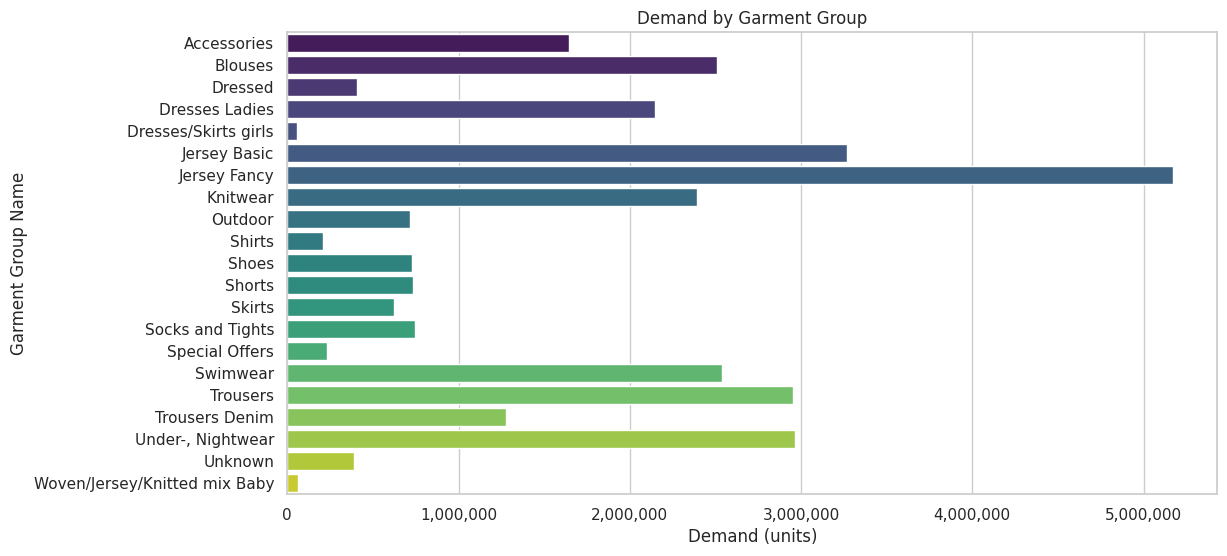

In [ ]:
# If not, replace it with the actual DataFrame containing the demand information

# Get the top 10 departments by demand
demand_by_category = merged_df.groupby(['garment_group_name']).size().reset_index(name='demand')

top_garment_group = demand_by_category.groupby('garment_group_name')['demand'].sum().nlargest(21).index

# Filter the DataFrame for the top 10 departments
top_garment_group_data = demand_by_category[demand_by_category['garment_group_name'].isin(top_garment_group)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 departments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='garment_group_name', data=top_garment_group_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))


plt.title('Demand by Garment Group')
plt.xlabel('Demand (units)')
plt.ylabel('Garment Group Name')
plt.show()

In [ ]:
# Assuming 'df_article_info' is your DataFrame
num_departments = df_article_info['department_name'].nunique()

print(f"Number of Departments: {num_departments}")

Number of Departments: 250


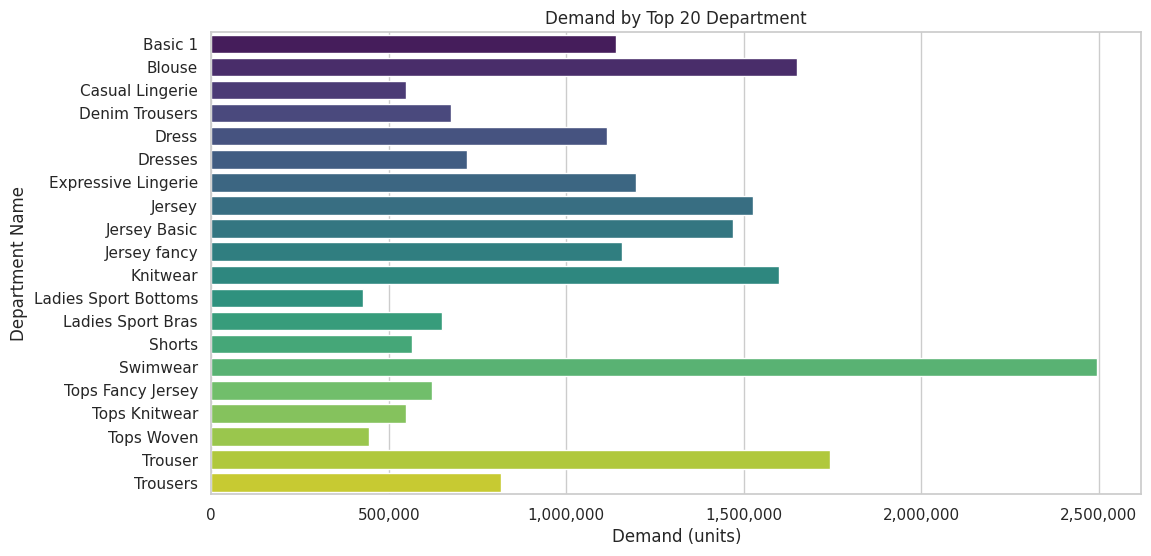

In [ ]:
# If not, replace it with the actual DataFrame containing the demand information

# Get the top 10 departments by demand
demand_by_category = merged_df.groupby(['department_name']).size().reset_index(name='demand')

top_garment_group = demand_by_category.groupby('department_name')['demand'].sum().nlargest(20).index

# Filter the DataFrame for the top 10 departments
top_garment_group_data = demand_by_category[demand_by_category['department_name'].isin(top_garment_group)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 departments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='department_name', data=top_garment_group_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))

plt.title('Demand by Top 20 Department')
plt.xlabel('Demand (units)')
plt.ylabel('Department Name')
plt.show()

In [ ]:
# Assuming 'df_article_info' is your DataFrame
num_product_types = df_article_info['product_type_name'].nunique()

print(f"Number of Product Types: {num_product_types}")

Number of Product Types: 131


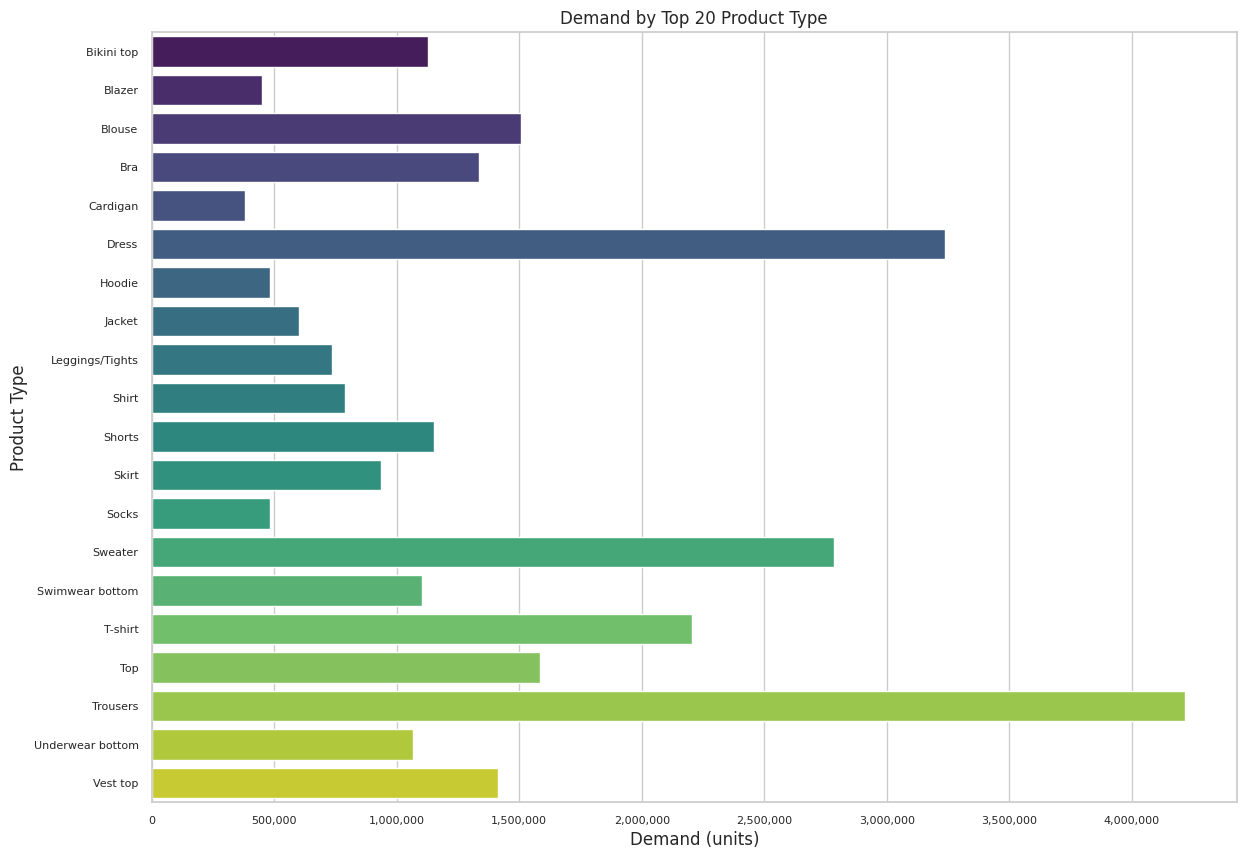

In [ ]:
# Get the top 10 departments by demand
demand_by_category = merged_df.groupby(['product_type_name']).size().reset_index(name='demand')

top_product_type = demand_by_category.groupby('product_type_name')['demand'].sum().nlargest(20).index

# Filter the DataFrame for the top 10 departments
top_product_type_data = demand_by_category[demand_by_category['product_type_name'].isin(top_product_type)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 departments
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='demand', y='product_type_name', data=top_product_type_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.title('Demand by Top 20 Product Type')
plt.xlabel('Demand (units)')
plt.ylabel('Product Type')
plt.show()

In [ ]:
# Assuming 'df_article_info' is your DataFrame
num_product_groups = df_article_info['product_group_name'].nunique()

print(f"Number of Product Groups: {num_product_groups}")

Number of Product Groups: 19


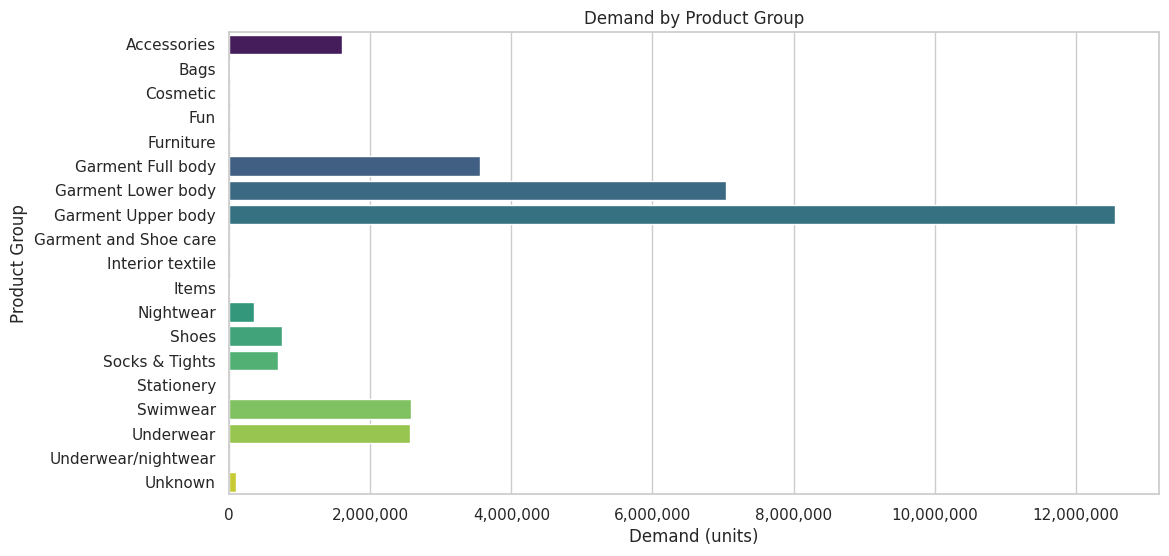

In [ ]:
# Get the top 10 departments by demand
demand_by_category = merged_df.groupby(['product_group_name']).size().reset_index(name='demand')

top_product_group = demand_by_category.groupby('product_group_name')['demand'].sum().nlargest(19).index

# Filter the DataFrame for the top 10 departments
top_product_group_data = demand_by_category[demand_by_category['product_group_name'].isin(top_product_group)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 departments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='product_group_name', data=top_product_group_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))

plt.title('Demand by Product Group')
plt.xlabel('Demand (units)')
plt.ylabel('Product Group')
plt.show()

In [ ]:
# Assuming 'df_article_info' is your DataFrame
num_indexes = df_article_info['index_name'].nunique()

print(f"Number of Indexes: {num_indexes}")

Number of Indexes: 10


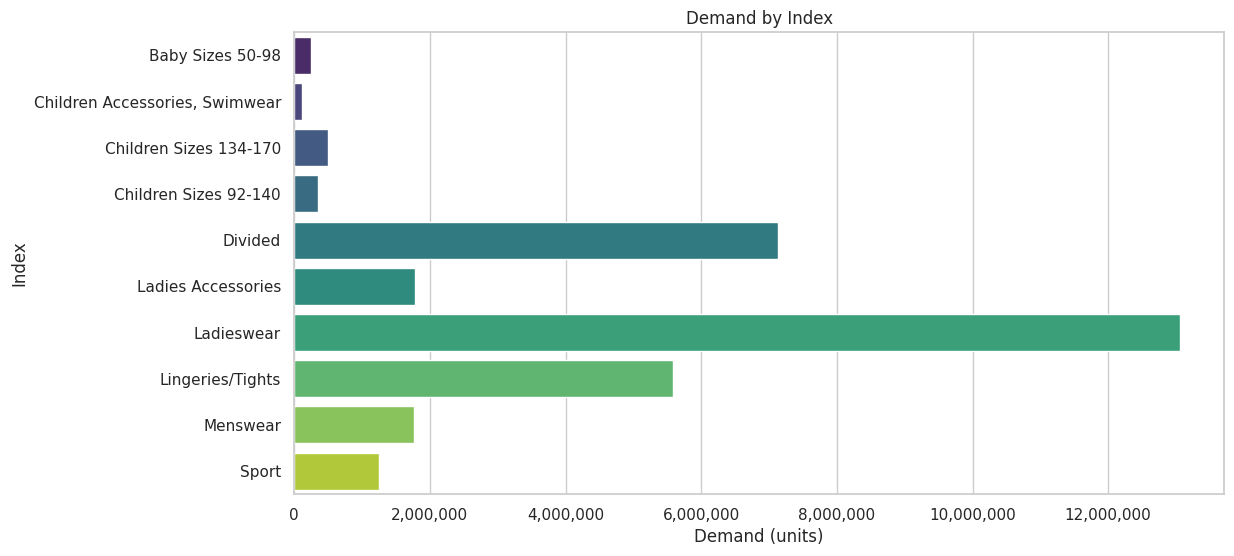

In [ ]:
# Get the top 10 departments by demand
demand_by_category = merged_df.groupby(['index_name']).size().reset_index(name='demand')

top_index = demand_by_category.groupby('index_name')['demand'].sum().nlargest(10).index

# Filter the DataFrame for the top 10 departments
top_index_data = demand_by_category[demand_by_category['index_name'].isin(top_index)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 departments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='index_name', data=top_index_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))

plt.title('Demand by Index')
plt.xlabel('Demand (units)')
plt.ylabel('Index')
plt.show()

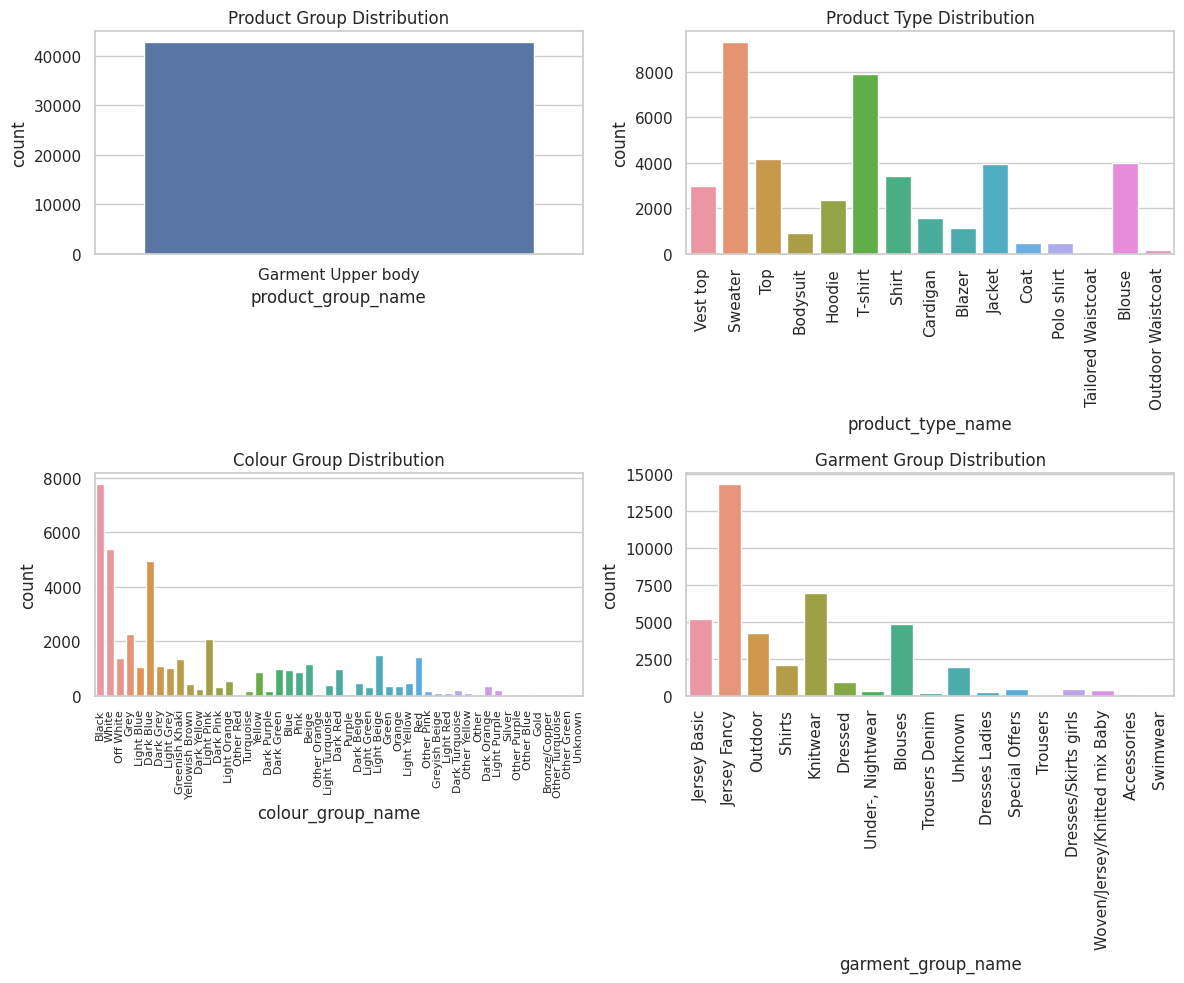

In [ ]:
# Set the style of the visualization (optional)
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

df_filtered = df_article_info[df_article_info['product_group_name'] == 'Garment Upper body']

# Bar chart for product_type_name
sns.countplot(x='product_group_name', data=df_filtered, ax=axes[0, 0])
axes[0, 0].set_title('Product Group Distribution')
axes[0, 0].tick_params(axis='x', rotation=0)  # Rotate x-axis labels for better visibility

# Bar chart for department_name
sns.countplot(x='product_type_name', data=df_filtered, ax=axes[0, 1])
axes[0, 1].set_title('Product Type Distribution')
axes[0, 1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Bar chart for colour_group_name
sns.countplot(x='colour_group_name', data=df_filtered, ax=axes[1, 0])
axes[1, 0].set_title('Colour Group Distribution')
axes[1, 0].tick_params(axis='x', rotation=90, labelsize=8)  # Rotate x-axis labels for better visibility


# Bar chart for garment_group_name
sns.countplot(x='garment_group_name', data=df_filtered, ax=axes[1, 1])
axes[1, 1].set_title('Garment Group Distribution')
axes[1, 1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
num_transactions = len(df)
print(num_transactions)

start_date = df['t_dat'].min()
end_date = df['t_dat'].max()

print(f"Time frame of transactions: {start_date} to {end_date}")

31788324
Time frame of transactions: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


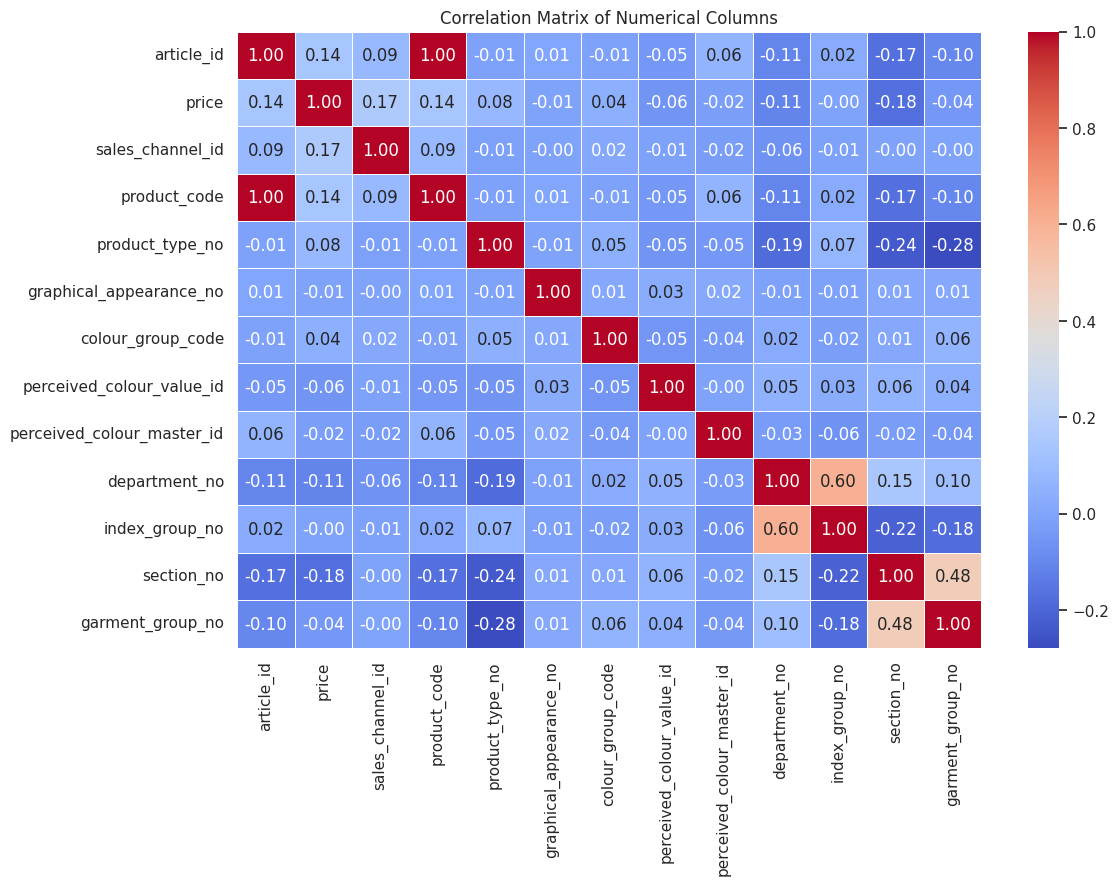

In [ ]:
# Assuming 'df' is your DataFrame with transactional data
# Considering only numerical columns for simplicity
numerical_columns = merged_df.select_dtypes(include=['int64', 'float64']).columns

# Calculate the correlation matrix
correlation_matrix = merged_df[numerical_columns].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

<ipython-input-92-36537ffec677>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_df[numerical_columns].corr()


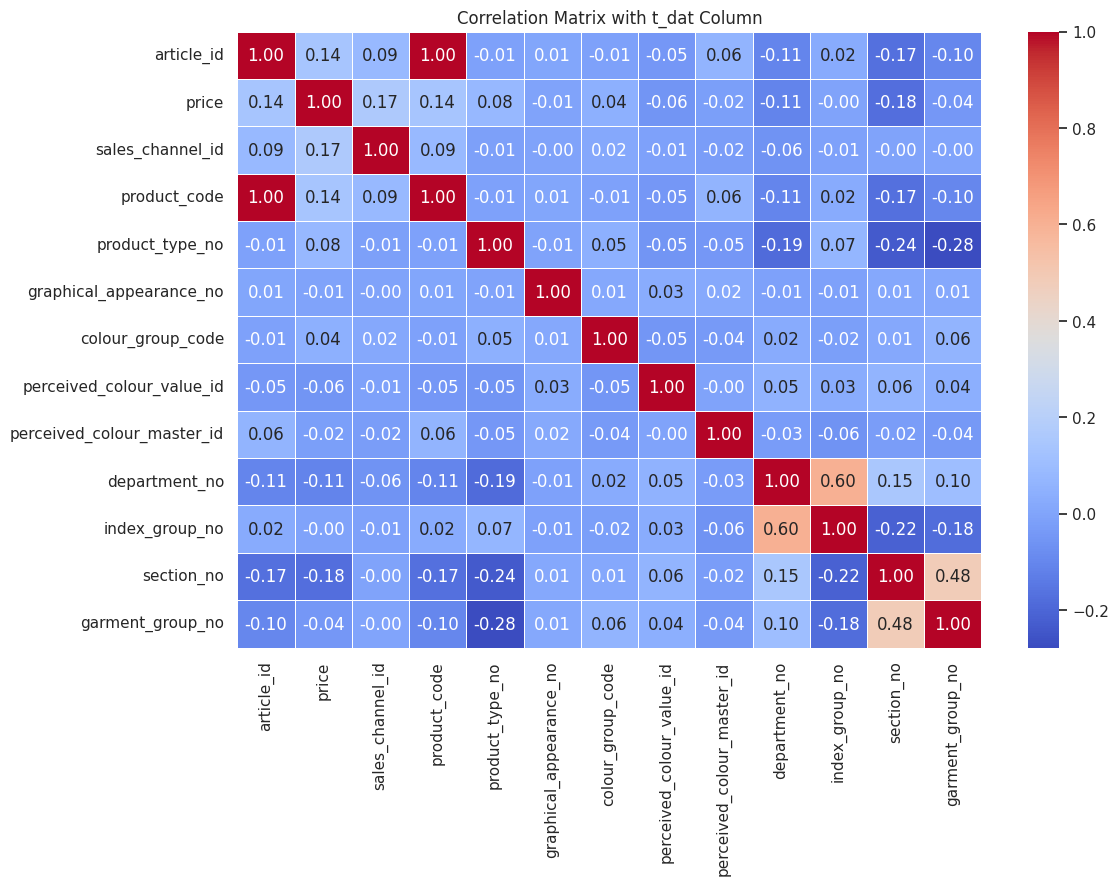

In [ ]:
# Assuming 'df' is your DataFrame with transactional data
# Considering only numerical columns for simplicity
numerical_columns = merged_df.select_dtypes(include=['int64', 'float64']).columns

# Add 't_dat' column to the numerical columns
numerical_columns = ['t_dat'] + list(numerical_columns)

# Calculate the correlation matrix
correlation_matrix = merged_df[numerical_columns].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix with t_dat Column')
plt.show()

# LSTM Model (Time Series)

In [ ]:
# Extract the time series data as a NumPy array
data = df['t_dat'].values

# Normalize the data (scaling it between 0 and 1)
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1))

# Define the number of past time steps to use for prediction
n_steps = 10

# Create sequences of data with n_steps time steps
X = np.array([data[i:i + n_steps] for i in range(len(data) - n_steps)])
y = data[n_steps:]

X, y = np.array(X), np.array(y)

In [ ]:
# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build an LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
794708/794708 [==============================] - 6836s 9ms/step - loss: 99516792832.0000
Epoch 2/10
794708/794708 [==============================] - 6787s 9ms/step - loss: 1948643.7500
Epoch 3/10
773829/794708 [============================>.] - ETA: 2:52 - loss: 0.0938

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

In [ ]:
# Inverse transform the predictions to the original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Plot the actual vs. predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()